# Adversarial Search: Playing Connect 4


## Instructions

Total Points: Undegraduates 100, graduate students 110

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

Note that [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [10 point]

Define the components of the search problem:

* Initial state: The board will be empty at the beginning of a game. Each turn (every time an agent has to return a value), the board will be given to the agent after the opponent makes a move and the board reflects that move.
* Actions: Putting your color at next available space from the bottom of any column that is not full (Drop a piece into a column)
* Transition model: Once a piece is dropped into a column, the board will now reflect that change and the piece will permanently be in that location. The x,y coordinate of the board (2d array) will now be the color which corresponds with your player (-1 for yellow/ 1 for red).
* Goal state: Whichever player you are, your pieces (which are shown by 1's or -1's in the 2d array) create 4 in a row horizontally, vertically, or diagonally.

How big is the state space? Give an estimate and explain it.

Given a board that is width N and height H, the state space will be NxH because the board is a 2d array and each x,y coordinate needs to be represented in the array. For a standard 7x6 board, the state space would be 42.

How big is the game tree that minimax search will go through? Give an estimate and explain it.

Since you can drop a piece in any of the columns, then the branching factor of the minmax search will expand by that every single time a move is made. Also, there are NxH amount of moves to be made if the board goes all the way to the end. This means that the biggest possible tree that can be made is NxH^N ((6*7)^7 = 230,539,333,248). The min max tree that we will be using will use alpha-beta pruning which means that the agent will not search parts of the tree and it will ultimately never become the maximum size. 

## Task 2: Game Environment and Random Agent [25 point]

Use a numpy character array as the board.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), I use 1 and -1 to represent the players. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player whose next move it is and who the agent should play.

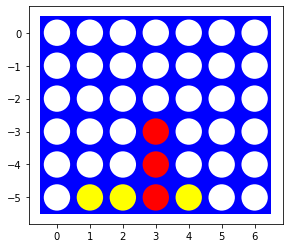

In [2]:
# Visualization code by Randolph Rankin

import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = [[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]]
visualize(board)

Implement helper functions for:

* The transition model $result(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
import copy
# Your code/ answer goes here.
def actions(s):
    moves = []
    for i in range(len(s[0])):
        j = len(s) - 1
        while s[j][i] != 0 and j >= 0:
            j -= 1
        if j != -1:
            moves.append((i,j))
    return moves

def result(s,p,a):
    state = copy.deepcopy(s)
    if p == 'yellow':
        state[a[1]][a[0]] = -1
    elif p == 'red':
        state[a[1]][a[0]] = 1
    return state

def checkArrayFor4InRow(i):
    cur = 0
    count = 1
    for j in i:
        if j != cur or j == 0:
            cur = j
            count = 1
        else:
            count += 1
            if count == 4: return cur
    return 0
    
def checkRows(s):
    for i in s:
        inRow = checkArrayFor4InRow(i)
        if inRow != 0: return inRow
    return 0

def checkCols(s):
    flipped = np.array(s).T
    return checkRows(flipped)

def checkDiags(s):
    numDiags = len(s)+len(s[0])-6
    for diags in range(numDiags):
        i = np.diag(s, int(0-numDiags/2+diags+1))
        inRow = checkArrayFor4InRow(i)
        if inRow != 0: return inRow
    return 0
    
def check_board(s):
    return len(s)*len(s[0])-np.count_nonzero(s)

def terminal(s):
    return (checkRows(s) != 0 or checkCols(s) != 0 or checkDiags(s) != 0 
        or checkDiags(np.fliplr(s)) != 0 or check_board(s) == 0)

def check_win(s):
    return checkRows(s) or checkCols(s) or checkDiags(s) or checkDiags(np.fliplr(s))

def utility(s, player):
    win = check_win(s)
    if win != 0:
        if player == 'yellow':
            if win == -1: return 1
            else: return -1
        if player == 'red':
            if win == 1: return 1
            else: return -1
    if check_board(s) == 0: return 0
    return None

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action. Use an agent function definition with the following signature (arguments):

`def random_player(board, player = None): ...`

The argument `player` is used for agents that do not store what color they are playing. The value passed on by the environment should be 1 ot -1 for player red and yellow, respectively.  See [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) for an example.

In [4]:
import random

# Your code/ answer goes here.
def random_player(board, player = None):
    return random.choice(actions(board))

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how the environment uses the agent functions to play against each other.

How often does each player win? Is the result expected?

In [5]:
# Your code/ answer goes here.
def switch_player(player, red, yellow):
    if player == 'red':
        return 'yellow', yellow
    else:
        return 'red', red

def play(yellow, red, N = 1000, createBoard = empty_board, showWins = False):
    """Let two agents play each other N times. x starts. x and y are agent functions that 
    get the board as the percept and return their next action."""
    results = {'yellow': 0, 'red': 0, 'draw': 0}
    
    for i in range(N):
        board = createBoard()
        player, fun = 'yellow', yellow
    
        while True:
            a = fun(board, player)
            board = result(board, player, a)

            win = check_win(board)  
            if win == 1:
                if showWins: visualize(board)
                results['red'] += 1
                break
            elif win == -1:
                if showWins: visualize(board)
                results['yellow'] += 1
                break
                
            if check_board(board) == 0:
                results['draw'] += 1
                break
            
            player, fun = switch_player(player, red, yellow)   
    
    return results

It sees that player yellow has an advantage (yellow plays first)

## Task 3: Minimax Search with Alpha-Beta Pruning

### Implement the Search [20 points] 

Implement minimax search starting from a given board for specifying the player.
You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).

__Important Notes:__ 
* Make sure that all your agent functions have a signature consistent with the random agent above and that it [uses a class to store state information.](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)
This is essential to be able play against agents from other students later.
* The search space for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$) and/or changing the winning rule to connect 3 instead of 4.

In [6]:
def empty_small_board(shape=(4, 4)):
    return np.full(shape=shape, fill_value=0)

In [7]:
import math
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def other(player): 
    if player == 'yellow': return 'red'
    else: return 'yellow'
    
def alpha_beta_search(board, player = 'yellow'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    return move
#     return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

In [8]:
class MinMaxAlphaBeta:
    def __init__(self, search_func = alpha_beta_search, cutoff = None):
        self.search_func = search_func
        self.cutoff = cutoff
    
    def act(self, board, player = 'yellow'):
        if self.cutoff: return self.search_func(board, player=player, cutoff = self.cutoff)
        return self.search_func(board, player=player)
    
agent = MinMaxAlphaBeta(search_func = alpha_beta_search)

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

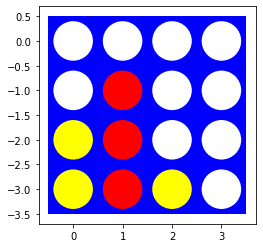

CPU times: user 13.8 ms, sys: 51 µs, total: 13.8 ms
Wall time: 13.8 ms
(1, 0)


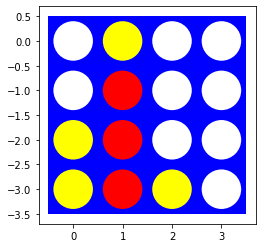

In [9]:
# Your code/ answer goes here.
blose = [[0, 0, 0, 0],
         [0, 1, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, -1, 0]]
visualize(blose)
%time r = agent.act(blose, player='yellow')
print(r)
r_result = result(blose, 'yellow',  r)
visualize(r_result)

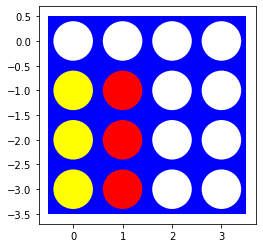

CPU times: user 4.5 ms, sys: 19 µs, total: 4.52 ms
Wall time: 4.53 ms
(0, 0)


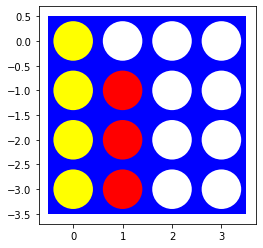

In [10]:
# Your code/ answer goes here.
b1 = [[0, 0, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, 0, 0]]
visualize(b1)
%time r = agent.act(b1, player='yellow')
print(r)
r_result = result(b1, 'yellow',  r)
visualize(r_result)

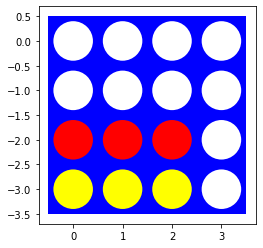

CPU times: user 113 ms, sys: 893 µs, total: 114 ms
Wall time: 114 ms
(3, 3)


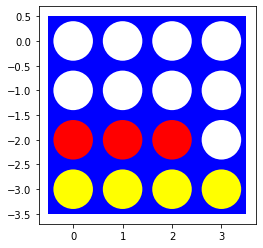

In [11]:
# Your code/ answer goes here.
b2 = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 0],
         [-1, -1,-1, 0]]
visualize(b2)
%time r = agent.act(b2, player='yellow')
print(r)
r_result = result(b2, 'yellow',  r)
visualize(r_result)

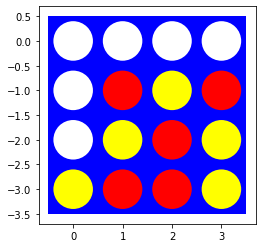

CPU times: user 8.73 ms, sys: 74 µs, total: 8.81 ms
Wall time: 8.84 ms
(3, 0)


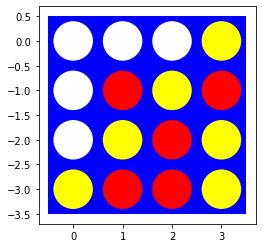

In [12]:
# Your code/ answer goes here.
b3 = [[0, 0, 0, 0],
         [0, 1, -1, 1],
         [0, -1, 1, -1],
         [-1, 1, 1, -1]]
visualize(b3)
%time r = agent.act(b3, player='yellow')
print(r)
r_result = result(b3, 'yellow',  r)
visualize(r_result)

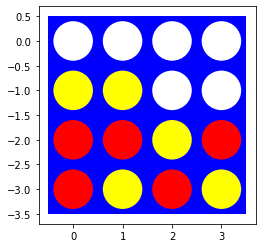

CPU times: user 1.41 ms, sys: 0 ns, total: 1.41 ms
Wall time: 1.42 ms
(0, 0)


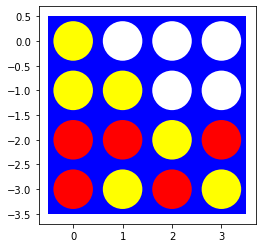

In [13]:
# Your code/ answer goes here.
b4 = [[0, 0, 0, 0],
         [-1, -1, 0, 0],
         [1, 1, -1, 1],
         [1, -1, 1, -1]]
visualize(b4)
%time r = agent.act(b4, player='yellow')
print(r)
r_result = result(b4, 'yellow',  r)
visualize(r_result)

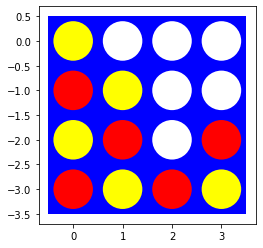

CPU times: user 1.17 ms, sys: 10 µs, total: 1.18 ms
Wall time: 1.18 ms
(2, 2)


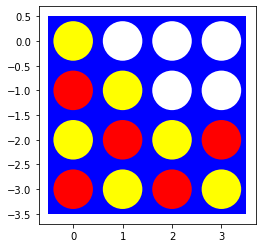

In [14]:
# Your code/ answer goes here.
b5 = [[-1, 0, 0, 0],
         [1, -1, 0, 0],
         [-1, 1, 0, 1],
         [1, -1, 1, -1]]
visualize(b5)
%time r = agent.act(b5, player='yellow')
print(r)
r_result = result(b5, 'yellow',  r)
visualize(r_result)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [15]:
# Your code/ answer goes here.
for i in range(4, 5):
    growing_board = empty_board(shape=(4, i))
    print(i,'x',4)
    %time r = agent.act(growing_board, player='yellow')

4 x 4
CPU times: user 1.9 s, sys: 13 ms, total: 1.92 s
Wall time: 1.91 s


### Move ordering [5 points]

Starting the search with better moves will increase the efficiency of alpha-beta pruning. Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

After looking up strategies for Connect 4, I found that playing towards the middle of the board is always better because it allows for more moves to be able to win. For the ordering, I chose to return my actions array to have the center columns first and in order of center to the outside columns since the center columns will have a higher chance of finding the best solution first. 
Ex. [1,2,3,4,5] => [3,2,4,5,1]

In [16]:
import time
# Your code/ answer goes here.
normalActions = []
for i in range(5):
    growing_board = empty_small_board()
    tic = time.perf_counter()
    agent.act(growing_board, player='yellow')    
    toc = time.perf_counter()
    normalActions.append(toc-tic)

In [17]:
# Your code/ answer goes here.
def actions(s, orderMoves = True):
    if orderMoves: return moveOrdering(s)
    moves = []
    for i in range(len(s[0])):
        j = len(s) - 1
        while s[j][i] != 0 and j >= 0:
            j -= 1
        if j != -1:
            moves.append((i,j))
    return moves

def moveOrdering(s):
    moves = []
    highIndex = int(len(s[0])/2)
    lowIndex = highIndex - 1
    while lowIndex >= 0 or highIndex < len(s[0]):
        if highIndex < len(s[0]):
            j = len(s) - 1
            while s[j][highIndex] != 0 and j >= 0:
                j -= 1
            if j != -1:
                moves.append((highIndex,j))
            highIndex += 1
            
        if lowIndex >= 0:
            j = len(s) - 1
            while s[j][lowIndex] != 0 and j >= 0:
                j -= 1
            if j != -1:
                moves.append((lowIndex,j))
            lowIndex -= 1
    return moves

In [18]:
import copy
import math
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def other(player): 
    if player == 'yellow': return 'red'
    else: return 'yellow'
    
def alpha_beta_search(board, player = 'yellow'):
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    return move
#     return { "move": move, "value": value }

def max_value_ab(state, player, alpha, beta):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
       
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"max: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtracking.")
        return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab(result(state, player, a), player, alpha, beta)
        if DEBUG >= 2: print(f"max: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta:
            if DEBUG >= 2: print(f"     v>=beta ({v}>={beta}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # return utility of state is a terminal state
    v = utility(state, player)
    if DEBUG >= 2: print(f"min: {state} [alpha,beta]=[{alpha},{beta}] v={v}")
    if v is not None: 
        if DEBUG >= 2: print(f"     found terminal state. backtacking.")
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab(result(state, other(player), a), player, alpha, beta)
        if DEBUG >= 2: print(f"min: {state} (backtracked) [alpha,beta]=[{alpha},{beta}] v={v2}")
        
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: 
            if DEBUG >= 2: print(f"     v<=alpha ({v}<={alpha}): pruning remaining subtree (actions). backtracking.")
            return v, move
    
    return v, move

agent = MinMaxAlphaBeta(search_func = alpha_beta_search)

In [19]:
orderedActions = []
for i in range(5):
    growing_board = empty_small_board()
    tic = time.perf_counter()
    agent.act(growing_board, player='yellow')    
    toc = time.perf_counter()
    orderedActions.append(toc-tic)

In [20]:
import pandas as pd

df = pd.DataFrame({
    'Unordered Actions': normalActions, 
    'Ordered Actions': orderedActions,
})
print(df.mean())
df

Unordered Actions    1.922130
Ordered Actions      4.865674
dtype: float64


,Unordered Actions,Ordered Actions
0,1.933427,4.777807
1,1.942895,4.746947
2,1.901537,4.854838
3,1.925762,4.943525
4,1.907030,5.005252


I think that because the ordering is tested on a 4x4 board, the logic explained above is not as good because of the nature of the board. The because the middle moves cannot make diagonals as much, the 4x4 testing is not a good demonstration of how this ordering would affect a bigger board.

### The first few moves [5 points]

Start with an empty board. This is the worst case scenario for minimax search since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

We can hard code a few options for the first move for both both players (red or yellow). Especially when the first move takes the most time, this is a good idea because an if statement will be constant time and you can still guarentee that the optimal move is made. We can do this for as many iterations as we want, but it becomes harder because there becomes n^size of row number of moves that could possibly be made which makes it hard to make if statements for them all.

In [21]:
# Your code/ answer goes here.
def firstMove(board, player):
    if board[len(board)-1][int(len(board[0])/2)] == 0: return (int(len(board[0])/2), len(board)-1)
    return (int(len(board[0])/2-1), len(board)-1)

def alpha_beta_search(board, player = 'yellow'):
    if check_board(board) > len(board)*len(board[0])-2: return firstMove(board, player) 
    """start the search."""
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    return move

agent = MinMaxAlphaBeta(search_func = alpha_beta_search)

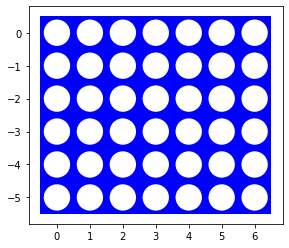

CPU times: user 14 µs, sys: 1e+03 ns, total: 15 µs
Wall time: 16 µs
(3, 5)


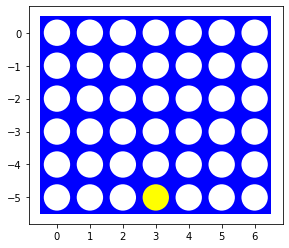

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 16 µs
(2, 5)


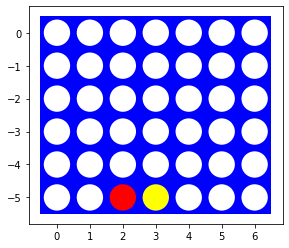

In [22]:
first_move_board = empty_board()
visualize(first_move_board)
%time r = agent.act(first_move_board, player='yellow')
print(r)
r_result = result(first_move_board, 'yellow',  r)
visualize(r_result)
%time r = agent.act(r_result, player='red') 
print(r)
r_result = result(r_result, 'red',  r)
visualize(r_result)

### Playtime [5 points]

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [23]:
# Your code/ answer goes here.
%time display(play(agent.act, random_player, N = 50, createBoard = empty_small_board))

{'yellow': 18, 'red': 0, 'draw': 32}

CPU times: user 1min 17s, sys: 311 ms, total: 1min 18s
Wall time: 1min 18s


Yellow now wins the majority of the games because of the minmax search. It draws and loses some of the times because of the random choices. The minmax is expecting the other agent to make the best possible moves also so when it doesn't, the algorithm isn't perfect. When it plays itself on a 4x4 board, the minmax search will always draw because of the nature of the small board won't let a perfect algorithm win. However, on a normal sized board, the minmax search that moves first will always win and the win over 90% of the time against a random agent.

## Task 4: Heuristic Alpha-Beta Tree Search

### Heuristic evaluation function [15 points]

Define and implement a heuristic evaluation function.

Heuristic for utility of state. Returns score for a node:
- 1. For terminal states it returns the utility. 
- 2. For non-terminal states, it calculates a weighted linear function using features of the state. 
    The features we look at are 3 in a row/col/diagonal where the 4th square is empty. We assume that
    the more of these positions we have, the higher the chance of winning.
    We need to be careful that the utility of the heuristic stays between [-1,1]. 
    Note that the largest possible number of these positions is 4. I weigh the count by 0.2, 
    guaranteeing that is in the needed range.
    
Function Returns: heuistic value, terminal?

In [24]:
# Your code/ answer goes here.
def checkArrayFor3InRow(i,playerNum):
    c1 = np.array([0,playerNum,playerNum,playerNum])
    c2 = np.array([playerNum,playerNum,playerNum,0])
    return (str(c1).strip('[]') in str(i).strip('[]') or 
            str(c2).strip('[]') in str(i).strip('[]'))
    
def checkRowsFor3(s, playerNum):
    for i in s:
        inRow = checkArrayFor3InRow(np.array(i), playerNum)
        if inRow: return inRow
    return False

def checkColsFor3(s, playerNum):
    flipped = np.array(s).T
    return checkRowsFor3(flipped, playerNum)

def checkDiagsFor3(s, playerNum):
    numDiags = len(s)+len(s[0])-6
    for diags in range(numDiags):
        i = np.diag(s, int(0-numDiags/2+diags+1))
        inRow = checkArrayFor3InRow(np.array(i),playerNum)
        if inRow: return inRow
    return False

def eval_fun(state, player = 'yellow'):
    # terminal state?
    u = utility(state, player)
    if u is not None: return u, True
    
    playerNum = -1
    if player == 'red': playerNum = 1
        
    score = 0
    if checkRowsFor3(state, playerNum): score += .2
    if checkColsFor3(state, playerNum): score += .2
    if checkDiagsFor3(state, playerNum): score += .2
    if checkDiagsFor3(np.fliplr(state), playerNum): score += .2
    return score, False

### Cutting off search [10 points]

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [25]:
# global variables
DEBUG = 0 # 1 ... count nodes, 2 ... debug each node
COUNT = 0

def alpha_beta_search_cutoff(board, cutoff = None, player = 'x'):
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return move

def max_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth + 1, cutoff)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab_cutoff(result(state, other(player), a), player, alpha, beta, depth + 1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

In [26]:
agent1 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = None)
agent2 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 1)
agent3 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 2)
agent4 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 3)
agent5 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 4)
agent6 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 5)
agent7 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 10)
agent8 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 20)
agent9 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 50)
agent10 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 1000)
# %time r = agent1.act(first_move_board, player='yellow') 
# %time r = agent2.act(first_move_board, player='yellow') 
# %time r = agent3.act(first_move_board, player='yellow') 
# %time r = agent4.act(first_move_board, player='yellow') 
# %time r = agent5.act(first_move_board, player='yellow') 
# %time r = agent6.act(first_move_board, player='yellow') 
# %time r = agent7.act(first_move_board, player='yellow') 
# %time r = agent8.act(first_move_board, player='yellow') 
# %time r = agent9.act(first_move_board, player='yellow') 
# %time r = agent10.act(first_move_board, player='yellow')

Experiment with the same manually created boards as above to check if the agent spots wining opportunities.

In [27]:
testAgent = agent4

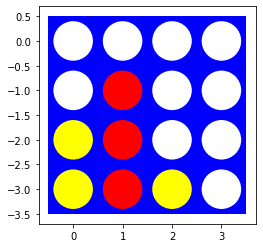

CPU times: user 39.9 ms, sys: 1.01 ms, total: 40.9 ms
Wall time: 40 ms
(1, 0)


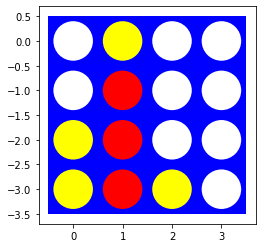

In [28]:
# Your code/ answer goes here.
blose = [[0, 0, 0, 0],
         [0, 1, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, -1, 0]]
visualize(blose)
%time r = testAgent.act(blose, player='yellow')
print(r)
r_result = result(blose, 'yellow',  r)
visualize(r_result)

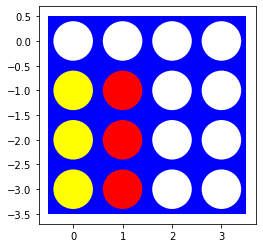

CPU times: user 23.6 ms, sys: 437 µs, total: 24 ms
Wall time: 23.6 ms
(0, 0)


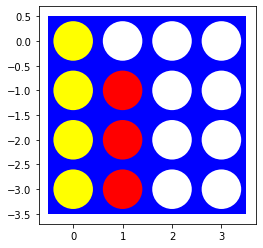

In [29]:
# Your code/ answer goes here.
b1 = [[0, 0, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, 0, 0],
         [-1, 1, 0, 0]]
visualize(b1)
%time r = testAgent.act(b1, player='yellow')
print(r)
r_result = result(b1, 'yellow',  r)
visualize(r_result)

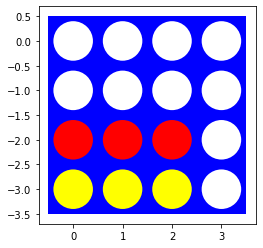

CPU times: user 39.9 ms, sys: 1.16 ms, total: 41.1 ms
Wall time: 40.2 ms
(3, 3)


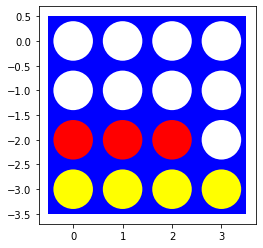

In [30]:
# Your code/ answer goes here.
b2 = [[0, 0, 0, 0],
         [0, 0, 0, 0],
         [1, 1, 1, 0],
         [-1, -1,-1, 0]]
visualize(b2)
%time r = testAgent.act(b2, player='yellow')
print(r)
r_result = result(b2, 'yellow',  r)
visualize(r_result)

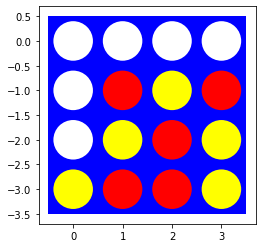

CPU times: user 22 ms, sys: 785 µs, total: 22.7 ms
Wall time: 22.1 ms
(3, 0)


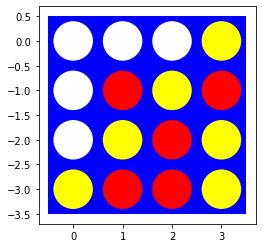

In [31]:
# Your code/ answer goes here.
b3 = [[0, 0, 0, 0],
         [0, 1, -1, 1],
         [0, -1, 1, -1],
         [-1, 1, 1, -1]]
visualize(b3)
%time r = testAgent.act(b3, player='yellow')
print(r)
r_result = result(b3, 'yellow',  r)
visualize(r_result)

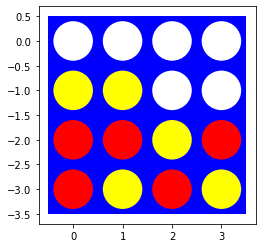

CPU times: user 22.7 ms, sys: 550 µs, total: 23.3 ms
Wall time: 22.8 ms
(2, 1)


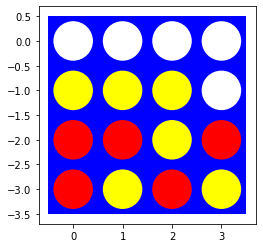

In [32]:
# Your code/ answer goes here.
b4 = [[0, 0, 0, 0],
         [-1, -1, 0, 0],
         [1, 1, -1, 1],
         [1, -1, 1, -1]]
visualize(b4)
%time r = testAgent.act(b4, player='yellow')
print(r)
r_result = result(b4, 'yellow',  r)
visualize(r_result)

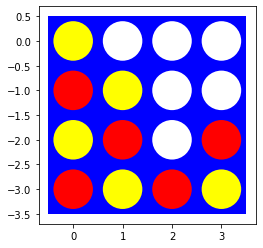

CPU times: user 12.1 ms, sys: 241 µs, total: 12.3 ms
Wall time: 12.1 ms
(2, 2)


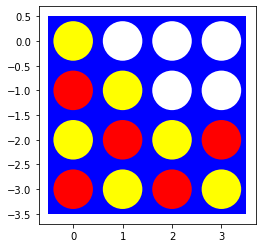

In [33]:
# Your code/ answer goes here.
b5 = [[-1, 0, 0, 0],
         [1, -1, 0, 0],
         [-1, 1, 0, 1],
         [1, -1, 1, -1]]
visualize(b5)
%time r = testAgent.act(b5, player='yellow')
print(r)
r_result = result(b5, 'yellow',  r)
visualize(r_result)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [34]:
# Your code/ answer goes here.
for i in range(4, 15):
    growing_board = empty_board(shape=(i, i))
    print(i,'x',i)
    %time r = testAgent.act(growing_board, player='yellow')

4 x 4
CPU times: user 38 ms, sys: 2.28 ms, total: 40.2 ms
Wall time: 38.2 ms
5 x 5
CPU times: user 79.4 ms, sys: 2.32 ms, total: 81.7 ms
Wall time: 79.2 ms
6 x 6
CPU times: user 144 ms, sys: 4.85 ms, total: 149 ms
Wall time: 145 ms
7 x 7
CPU times: user 233 ms, sys: 6.6 ms, total: 240 ms
Wall time: 233 ms
8 x 8
CPU times: user 359 ms, sys: 12.4 ms, total: 372 ms
Wall time: 361 ms
9 x 9
CPU times: user 518 ms, sys: 16.5 ms, total: 534 ms
Wall time: 519 ms
10 x 10
CPU times: user 723 ms, sys: 24.8 ms, total: 748 ms
Wall time: 726 ms
11 x 11
CPU times: user 965 ms, sys: 30.7 ms, total: 996 ms
Wall time: 968 ms
12 x 12
CPU times: user 1.26 s, sys: 35.3 ms, total: 1.3 s
Wall time: 1.26 s
13 x 13
CPU times: user 1.61 s, sys: 43.5 ms, total: 1.66 s
Wall time: 1.61 s
14 x 14
CPU times: user 2.04 s, sys: 55.6 ms, total: 2.1 s
Wall time: 2.04 s


### Playtime [5 points]

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [35]:
agent1 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 5)

In [36]:
# Your code/ answer goes here.
def eval_fun(state, player = 'yellow'):
    # terminal state?
    u = utility(state, player)
    if u is not None: return u, True
    
    playerNum = -1
    if player == 'red': playerNum = 1
        
    score = 0
    if checkRowsFor3(state, playerNum): score += .25
    if checkColsFor3(state, playerNum): score += .25
    if checkDiagsFor3(state, playerNum): score += .25
    if checkDiagsFor3(np.fliplr(state), playerNum): score += .25
    
    return score, False

def alpha_beta_search_cutoff(board, cutoff = None, player = 'yellow'):
    if check_board(board) > len(board)*len(board[0])-2: return firstMove(board, player) 
    """start the search. cutoff = None is minimax search with alpha-beta pruning."""
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab_cutoff(board, player, -math.inf, +math.inf, 0, cutoff)
    
    if DEBUG >= 1: print(f"Number of nodes searched (cutoff = {cutoff}): {COUNT}") 
    
    return move

def max_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    """player's best move."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state):
        v2, a2 = min_value_ab_cutoff(result(state, player, a), player, alpha, beta, depth + 1, cutoff)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    
    return v, move

def min_value_ab_cutoff(state, player, alpha, beta, depth, cutoff):
    """opponent's best response."""
    global DEBUG, COUNT
    COUNT += 1
    
    # cut off and terminal test
    v, terminal = eval_fun(state, player)
    if((cutoff is not None and depth >= cutoff) or terminal): 
        if(terminal): 
            alpha, beta = v, v
        if DEBUG >= 2: print(f"stopped at {depth}: {state} term: {terminal} eval: {v} [{alpha}, {beta}]" ) 
        return v, None
    
    v, move = +math.inf, None

    # check all possible actions in the state, update beta and return move with the smallest value
    for a in actions(state):
        v2, a2 = max_value_ab_cutoff(result(state, other(player), a), player, alpha, beta, depth + 1, cutoff)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    
    return v, move

In [37]:
agent2 = MinMaxAlphaBeta(search_func = alpha_beta_search_cutoff, cutoff = 2)

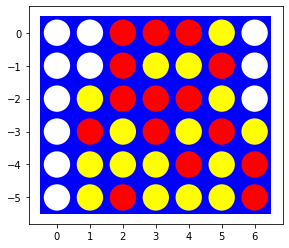

{'yellow': 1, 'red': 0, 'draw': 0}

CPU times: user 18.9 s, sys: 473 ms, total: 19.3 s
Wall time: 19 s


In [38]:
%time display(play(agent1.act, agent2.act, N = 1, createBoard = empty_board, showWins=True))